<a href="https://colab.research.google.com/github/AmritSDutta/colab_ml/blob/main/All_the_steps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install opendatasets

In [1]:
import opendatasets as od
import pandas as pd

od.download("https://www.kaggle.com/datasets/himanshunakrani/iris-dataset")

Skipping, found downloaded files in "./iris-dataset" (use force=True to force download)


In [2]:
df= pd.read_csv("/content/iris-dataset/iris.csv")

In [3]:
df.head()


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
from sklearn.preprocessing import LabelEncoder

# Creating a instance of label Encoder.
le = LabelEncoder()

# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(df['species'])

# Appending the array to our dataFrame
# with column name 'Purchased'
df["y"] = label
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species,y
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0


In [5]:
from sklearn.utils import shuffle
df_shuffled = shuffle(df)
df_shuffled.head()

,sepal_length,sepal_width,petal_length,petal_width,species,y
88,5.6,3.0,4.1,1.3,versicolor,1
136,6.3,3.4,5.6,2.4,virginica,2
10,5.4,3.7,1.5,0.2,setosa,0
140,6.7,3.1,5.6,2.4,virginica,2
115,6.4,3.2,5.3,2.3,virginica,2


In [39]:
y = df_shuffled["y"].to_numpy()
X = df_shuffled.copy().drop(["species","y"],axis=1).to_numpy()

**Standardize the data**


In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Trainning

In [37]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
output = classifier.fit(X_train, y_train)
print(f'Train output: {output.score(X_train, y_train)}')
print(f'Test output: {output.score(X_test,y_test)}')


Train output: 0.975
Test output: 0.9666666666666667


**Model explain: PermutationImportance**

In [18]:
!pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 2.4 MB/s eta 0:00:00


In [10]:
import eli5
from eli5.sklearn import PermutationImportance
dummy_df = df_shuffled.copy().drop(["species","y"],axis=1)

perm = PermutationImportance(classifier, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = dummy_df.columns.to_list(),)


Weight,Feature
0.2800 ± 0.1083,petal_width
0.2333 ± 0.0843,petal_length
0.0867 ± 0.0680,sepal_width
0.0333 ± 0.0422,sepal_length


**Model Explainability with Shap** [link text](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.html)

(30, 4)


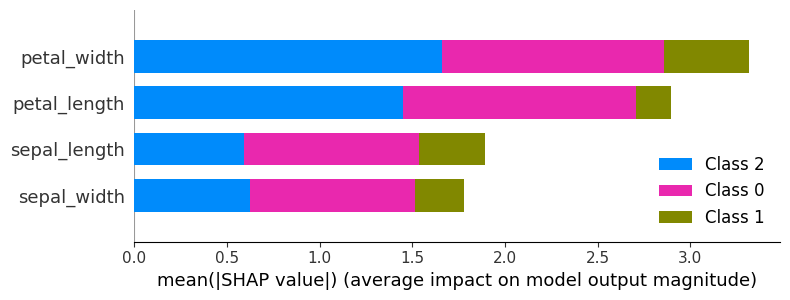

In [11]:
import shap

# explain the model's predictions using SHAP
explainer = shap.explainers.Linear(classifier, X_test, feature_names=dummy_df.columns)
shap_values = explainer(X_test)
print(shap_values.data.shape)

# visualize the model's dependence on the first feature
shap.summary_plot(shap_values)

In [62]:
!pip install skl2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.2 which is incompatible.
tensorflow 2.18.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0d

**Model optimization ONNX**

In [12]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
onnx_model = convert_sklearn(classifier, initial_types=initial_type)

with open("rf_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())


In [14]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.1 MB/s eta 0:00:00


Model Inference from ONNX model

In [13]:
import onnxruntime as ort
import numpy as np
from sklearn.metrics import accuracy_score
# Load ONNX model
session = ort.InferenceSession("rf_model.onnx")

# Prepare input
input_name = session.get_inputs()[0].name
input_data = X_test.astype(np.float32)

# Run inference
preds = session.run(None, {input_name: input_data})[0]
print(accuracy_score(y_test, preds))

0.9666666666666667


In [14]:
import torch
from torch.nn import functional as F
from torch import nn

torch_model = nn.Sequential(
    nn.Linear(4, 10),
    nn.ReLU(),
    nn.Linear(10, 3),
)
torch_model.compile()
print(torch_model)

Sequential(
  (0): Linear(in_features=4, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=3, bias=True)
)


In [15]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create Dataset and DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

In [16]:
from torch import optim
from torch import nn
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(torch_model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = torch_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")

Epoch [20/100], Loss: 0.0881
Epoch [40/100], Loss: 0.0109
Epoch [60/100], Loss: 0.0014
Epoch [80/100], Loss: 0.0014
Epoch [100/100], Loss: 0.0040


In [17]:
torch_model.eval()
with torch.no_grad():
    outputs = torch_model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    acc = accuracy_score(y_test_tensor, predicted)
    print(f"Test Accuracy: {acc * 100:.2f}%")


Test Accuracy: 100.00%


In [40]:
!pip install torch torchviz graphviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [19]:
from torchviz import make_dot
sample_input = X_test_tensor[0].unsqueeze(0)
make_dot(torch_model(sample_input), params=dict(torch_model.named_parameters())).render("iris_model", format="png")


'iris_model.png'

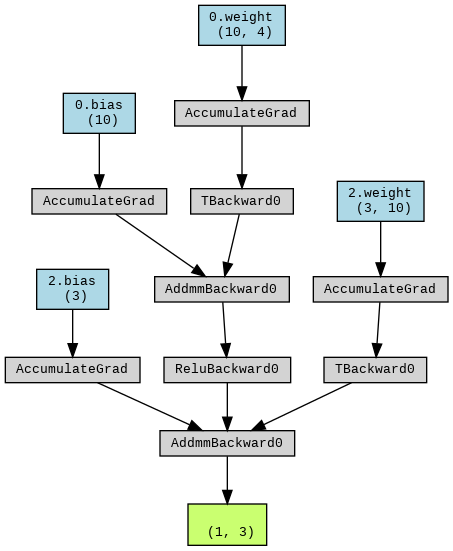

In [21]:
from IPython.display import Image
Image("iris_model.png")

<ipython-input-25-3c5c2fa49b8a>:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, data_to_explain.numpy(), feature_names=dummy_df.columns)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dis

<Figure size 640x480 with 0 Axes>

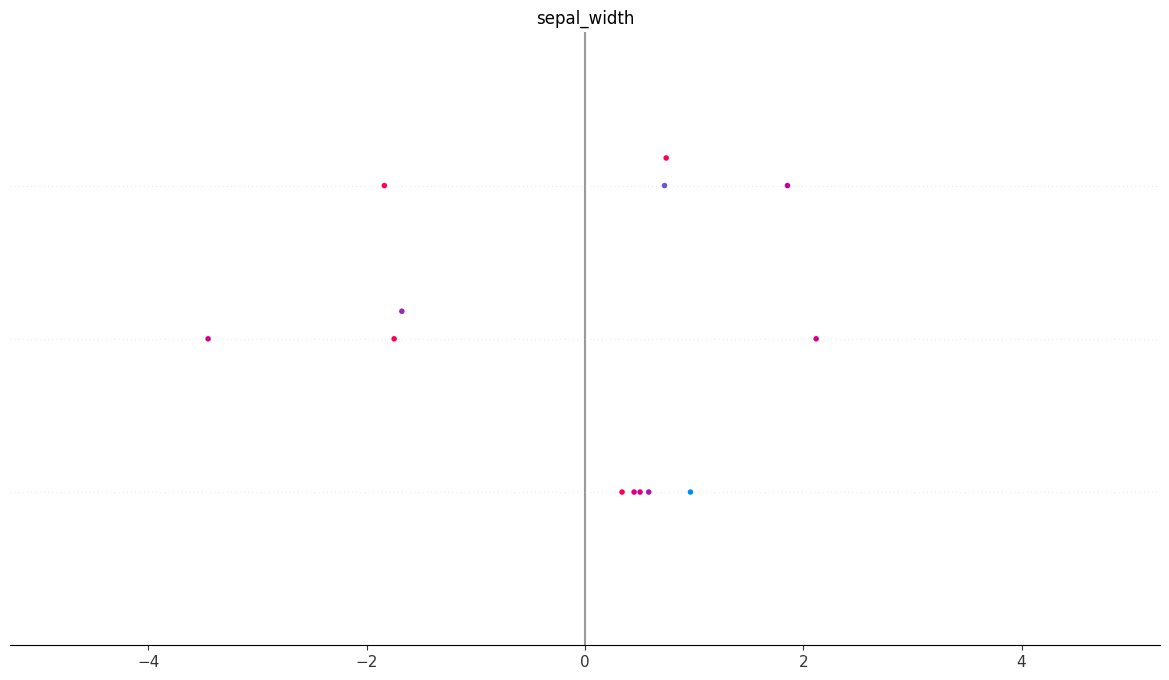

In [25]:
# SHAP Explainability
background = X_train_tensor[:20]
data_to_explain = X_test_tensor[:5]

explainer = shap.GradientExplainer(torch_model, background)
shap_values = explainer.shap_values(data_to_explain)

# Visualization
shap.summary_plot(shap_values, data_to_explain.numpy(), feature_names=dummy_df.columns)

In [29]:
# 5. Quantize the model (dynamic quantization)
quantized_model = torch.quantization.quantize_dynamic(
    torch_model, {nn.Linear}, dtype=torch.qint8
)

# 6. Evaluate the quantized model
with torch.no_grad():
    pred_quant = quantized_model(X_test_tensor).argmax(dim=1)
    acc_quant = accuracy_score(y_test_tensor, pred_quant)
    print(f"[After Quantization] Accuracy: {acc_quant * 100:.2f}%")

[After Quantization] Accuracy: 100.00%


In [36]:
import tensorflow as tf

from tensorflow import keras
from keras.layers import Dense

In [50]:
def train_model(_compiled_model, _X_train, _y_train, _X_valid, _y_valid, _model_file_name):
    _history = _compiled_model.fit(_X_train, _y_train,
                                   epochs=25,
                                   validation_data=(_X_valid, _y_valid),
                                   callbacks=[keras.callbacks.EarlyStopping(patience=2)]
                                   )
    _compiled_model.save(_model_file_name)


In [42]:
len(X_train)

120

In [ ]:
X_valid, y_valid = X_train[100:], y_train[100:]

In [51]:
tf_model = keras.models.Sequential()
tf_model.add(keras.layers.Flatten(input_shape=[4]))
tf_model.add(keras.layers.Dense(4, activation="relu"))
tf_model.add(keras.layers.Dense(10, activation="relu"))
tf_model.add(keras.layers.Dense(3, activation="softmax"))

tf_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=["accuracy"])
print(tf_model.summary())
tf_model.
model_file_name = 'iris_data_model.keras'

train_model(tf_model, X_train[:100], y_train[:100], X_train[100:], y_train[100:], model_file_name)

saved_model = keras.models.load_model(model_file_name)
score = saved_model.evaluate(X_test, y_test)
print('Score: ' + str(score))

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103 (412.00 B)

 Trainable params: 103 (412.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.3732 - loss: 1.2665 - val_accuracy: 0.2000 - val_loss: 1.1345
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3021 - loss: 1.1113 - val_accuracy: 0.4000 - val_loss: 1.0990
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4792 - loss: 1.0760 - val_accuracy: 0.5000 - val_loss: 1.0756
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5685 - loss: 1.0683 - val_accuracy: 0.5000 - val_loss: 1.0614
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4524 - loss: 1.0404 - val_accuracy: 0.3500 - val_loss: 1.0535
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3113 - loss: 1.0707 - val_accuracy: 0.3500 - val_loss: 1.0389
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3977 - loss: 1.0167 - val_accuracy: 0.5000 - val_loss: 1.0197
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6028 - loss: 1.0033 - val_accuracy: 0.5500 - val_loss: 1

<ipython-input-53-b136a17df93f>:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, data_to_explain, feature_names=dummy_df.columns)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.11/dist-packag

<Figure size 640x480 with 0 Axes>

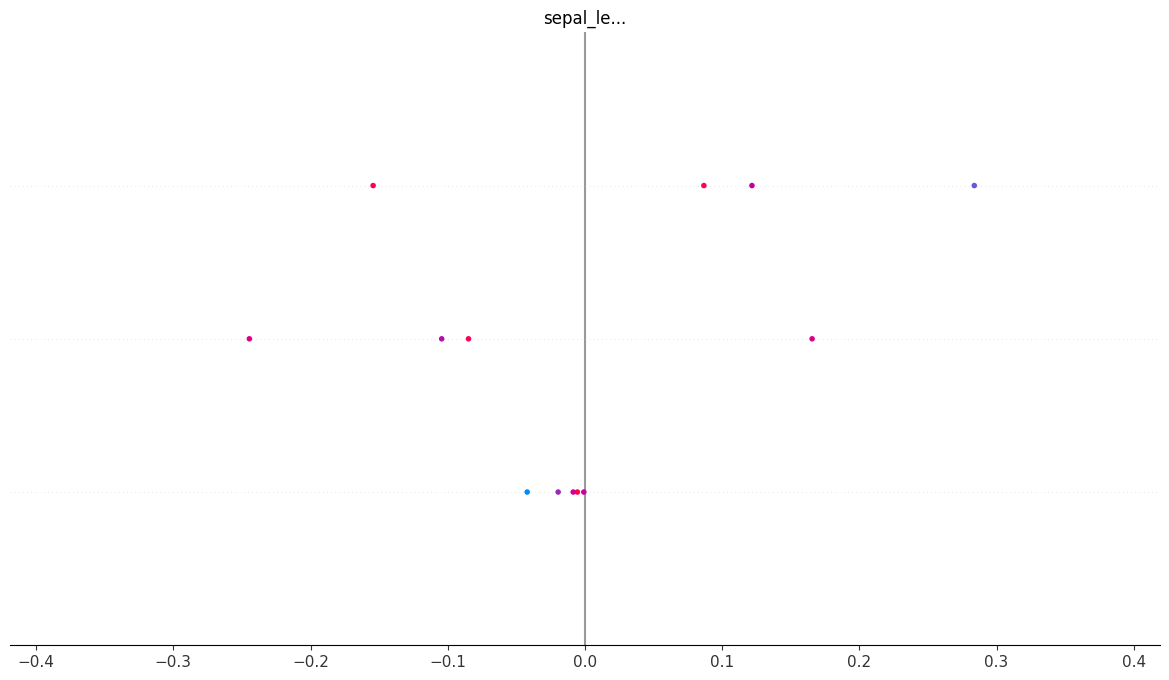

In [53]:
# SHAP Explainability
background = X_train[:20]
data_to_explain = X_test[:5]

explainer = shap.GradientExplainer(tf_model, background)
shap_values = explainer.shap_values(data_to_explain)

# Visualization
shap.summary_plot(shap_values, data_to_explain, feature_names=dummy_df.columns)